## **Before Augmentation**

In [1]:
%%capture
!pip install evaluate
!pip install pandas numpy matplotlib scikit-learn torch transformers tqdm emoji sentencepiece protobuf accelerate transformers[torch]

In [14]:
%%capture
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, 
                          BertTokenizerFast, XLMRobertaTokenizerFast)
from torch.utils.data import Dataset
import torch
import tqdm
import emoji
import re
from sklearn.metrics import accuracy_score, f1_score
from transformers import TrainingArguments, EarlyStoppingCallback, Trainer

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
import re
import emoji
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments)
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [4]:
train_df = pd.read_csv('./train.csv')
dev_df = pd.read_csv('./dev.csv')
df = pd.concat([train_df, dev_df], ignore_index=True)

# Drop missing values
df = df.dropna(subset=['text', 'label'])
df.reset_index(drop=True, inplace=True)
df

,id,text,label
0,3268,Indha ariya kandupidippin moolam neenga solla ...,0
1,6239,@vijayakumarp7959 unmai therincha nee pesu,0
2,5859,Inga erukka yella dev... boys vadakkan vadakk...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...,1
4,5136,Mumbai Bangalore la 80% percentage outsiders,1
...,...,...,...
6294,5860,This is done by those who want chaos in Tamil ...,0
6295,1441,"வடமாநிலத்தவருக்கு வேலை வாய்ப்பு கொடுப்பதை ,பணி...",0
6296,3253,நம்ம மேல எந்த தப்பும் இல்லை.... ஏன் என்றால் நா...,0
6297,4295,தம்பி உத்திரபிரதேசம் டெல்லி எல்லையில் உள்ள 90%...,1


In [5]:
# -------------------------------
# Text Preprocessing
# -------------------------------
# Function to clean each text
def preprocess_text(text):
    # Replace mentions
    text = re.sub(r'@\w+', '<USER>', text)
    
    # Replace hashtags
    text = re.sub(r'#\w+', '<HASHTAG>', text)
    
    # Convert emojis to text (e.g., 😊 -> :smiling_face_with_smiling_eyes:)
    text = emoji.demojize(text, delimiters=(" ", " "))  # adds spaces around emoji descriptions
    
    # Optional: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)
df.sample(10)

,id,text,label
1853,5063,Illa ya vera vera ratham.iruku,1
4388,607,Naga Tirupur Vela eilamal romba kastabadurom e...,0
3243,6001,Then why do you go to Tirupathi Perumal temple,0
4488,6809,வன்னியர் சார்பாக வாழ்த்துக்கள் கூடி வாழ்ந்தால்...,0
6097,1678,சீமான் சொல்வது எல்லாம் நடக்கிறது மக்கள் தான் ச...,0
4152,7400,Dei neenga dhaan andha so called Brainy jaadhi...,1
3346,5835,இது பூச்சாண்டி காட்டும் வகையில் உள்ளது குண்டி ...,0
654,1566,Already this video posted two years back now why,0
463,6211,"<USER>.761 Apo oru ambala Mattum 12 , 13 ponna...",0
4381,840,ஓட்டே ஒங்கள் கையில் உள்ள பெரியே ஆயுதம் அதையே உ...,0


In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [7]:
model_names = {
    'Tamil-BERT': 'l3cube-pune/tamil-bert',
    'LaBSE': 'sentence-transformers/LaBSE',
    'MuRIL-large': 'google/muril-large-cased',
    'XLM-Roberta-large': 'xlm-roberta-large',
    'mBERT': 'bert-base-multilingual-cased',
    'XLM-Roberta-base': 'xlm-roberta-base',
    'IndicBERT': 'ai4bharat/indic-bert',
    'MuRIL-base': 'google/muril-base-cased'
}

In [8]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        # Flatten the tensors to avoid extra dimension
        item = {key: encoding[key].squeeze(0) for key in encoding}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [9]:
training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    fp16=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,
    lr_scheduler_type="cosine",
    learning_rate=1e-5,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    dataloader_num_workers=4,
)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions), "macro_f1": f1_score(labels, predictions, average='macro')}

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
results_list = []
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)
# Train and evaluate each model separately
for model_name, model_path in model_names.items():
    print(f"Training {model_name}...")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    for param in model.parameters():
            param.data = param.data.contiguous()
    # Create datasets
    train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
    val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping],
    )

    # Train model
    trainer.train()

    # Evaluate model
    preds = trainer.predict(val_dataset)
    pred_labels = np.argmax(preds.predictions, axis=1)

    # Compute metrics
    acc = accuracy_score(val_labels, pred_labels)
    macro_f1 = f1_score(val_labels, pred_labels, average='macro')
    class_report = classification_report(val_labels, pred_labels, output_dict=True)
    conf_matrix = confusion_matrix(val_labels, pred_labels)
    print(f"Results for {model_name}:\nAccuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")

    # Save results
    results_list.append({
        "Model": model_name,
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix
    })

    # Clear GPU memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

Training Tamil-BERT...


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/tamil-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.673000,0.658518,0.633333,0.387755
2,0.617200,0.619103,0.672222,0.636898
4,0.538600,0.616084,0.698413,0.610730
6,0.461300,0.578235,0.734921,0.692498
8,0.380700,0.592368,0.726190,0.698316
10,0.348400,0.594022,0.734921,0.713838


Results for Tamil-BERT:
Accuracy: 0.7349, Macro F1: 0.6925
Training LaBSE...


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.634900,0.615656,0.654762,0.624628
2,0.467800,0.561478,0.719841,0.695388
4,0.261000,0.659910,0.773810,0.744772
6,0.168900,0.759264,0.775397,0.748067


Results for LaBSE:
Accuracy: 0.7198, Macro F1: 0.6954
Training MuRIL-large...


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.621300,0.599319,0.665873,0.655069
2,0.394500,0.490489,0.777778,0.750883
4,0.215400,0.657078,0.791270,0.761524
6,0.093600,0.698942,0.807937,0.790864


Results for MuRIL-large:
Accuracy: 0.7778, Macro F1: 0.7509
Training XLM-Roberta-large...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.666500,0.646712,0.633333,0.387755
2,0.582300,0.581702,0.677778,0.656441
4,0.415400,0.588878,0.739683,0.704641
6,0.317700,0.714606,0.730952,0.687681


Results for XLM-Roberta-large:
Accuracy: 0.6778, Macro F1: 0.6564
Training mBERT...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.655200,0.652453,0.607143,0.588088
2,0.489000,0.616633,0.685714,0.659110
4,0.340800,0.739135,0.726984,0.693583


Results for mBERT:
Accuracy: 0.6714, Macro F1: 0.6286
Training XLM-Roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.679300,0.636814,0.639683,0.435321
2,0.612500,0.600239,0.653175,0.622159
4,0.514700,0.630067,0.709524,0.671636
6,0.422100,0.630202,0.722222,0.700683


Results for XLM-Roberta-base:
Accuracy: 0.6532, Macro F1: 0.6222
Training IndicBERT...


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.670000,0.655451,0.633333,0.387755
2,0.617400,0.634030,0.644444,0.472054
4,0.454500,0.646551,0.672222,0.644304
6,0.420900,0.642832,0.688095,0.662498


Results for IndicBERT:
Accuracy: 0.6444, Macro F1: 0.4721
Training MuRIL-base...


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.677900,0.672578,0.633333,0.387755
2,0.654500,0.647927,0.633333,0.387755
4,0.598500,0.626355,0.639683,0.628352
6,0.509000,0.626614,0.650000,0.646521
8,0.445700,0.618939,0.700794,0.688430
10,0.291900,0.613845,0.732540,0.712456


Results for MuRIL-base:
Accuracy: 0.7032, Macro F1: 0.6758


In [11]:
results_df = pd.DataFrame(results_list)
results_df.to_csv("model_results_before_aug.csv", index=False)

In [12]:
results_df

,Model,Accuracy,Macro F1,Classification Report
0,Tamil-BERT,0.734921,0.692498,"{'0': {'precision': 0.7494623655913979, 'recal..."
1,LaBSE,0.719841,0.695388,"{'0': {'precision': 0.7716727716727717, 'recal..."
2,MuRIL-large,0.777778,0.750883,"{'0': {'precision': 0.795662100456621, 'recall..."
3,XLM-Roberta-large,0.677778,0.656441,"{'0': {'precision': 0.7525773195876289, 'recal..."
4,mBERT,0.671429,0.628572,"{'0': {'precision': 0.7157303370786516, 'recal..."
5,XLM-Roberta-base,0.653175,0.622159,"{'0': {'precision': 0.7193195625759417, 'recal..."
6,IndicBERT,0.644444,0.472054,"{'0': {'precision': 0.6480541455160744, 'recal..."
7,MuRIL-base,0.703175,0.675822,"{'0': {'precision': 0.7560386473429952, 'recal..."


/tmp/ipykernel_13839/912288673.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis", ax=ax[0])
/tmp/ipykernel_13839/912288673.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(model_names, rotation=15)
/tmp/ipykernel_13839/912288673.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=macro_f1_scores, palette="viridis", ax=ax[1])
/tmp/ipykernel_13839/912288673.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(mod

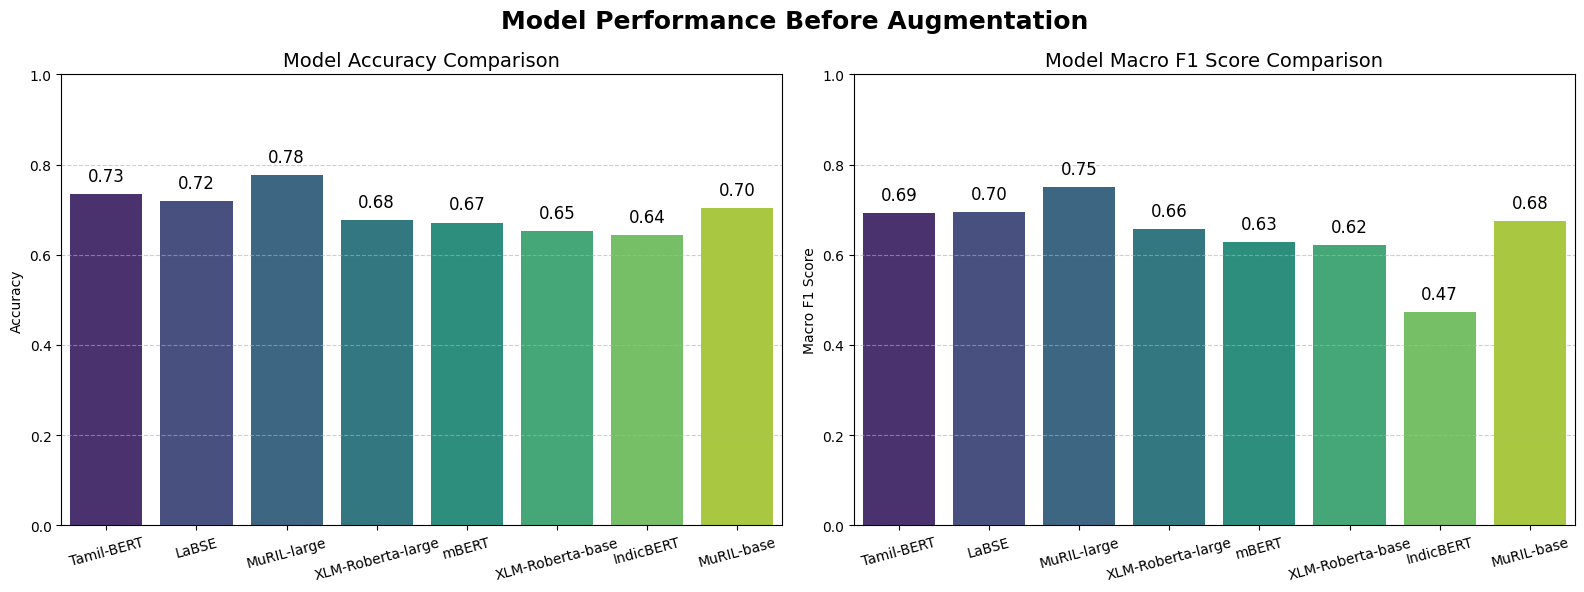

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract model names, accuracy, and macro F1 scores
model_names = [res["Model"] for res in results_list]
accuracies = [res["Accuracy"] for res in results_list]
macro_f1_scores = [res["Macro F1"] for res in results_list]  # Directly use stored Macro F1 scores

# Create figure with Accuracy and Macro F1 Score side-by-side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Model Performance Before Augmentation", fontsize=18, fontweight="bold")

# Plot Accuracy
sns.barplot(x=model_names, y=accuracies, palette="viridis", ax=ax[0])
ax[0].set_title("Model Accuracy Comparison", fontsize=14)
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1.0)
ax[0].set_xticklabels(model_names, rotation=15)
ax[0].grid(axis="y", linestyle="--", alpha=0.6)

# Add accuracy values
for i, acc in enumerate(accuracies):
    ax[0].text(i, acc + 0.02, f"{acc:.2f}", ha="center", va="bottom", fontsize=12)

# Plot Macro F1 Score
sns.barplot(x=model_names, y=macro_f1_scores, palette="viridis", ax=ax[1])
ax[1].set_title("Model Macro F1 Score Comparison", fontsize=14)
ax[1].set_ylabel("Macro F1 Score")
ax[1].set_ylim(0, 1.0)
ax[1].set_xticklabels(model_names, rotation=15)
ax[1].grid(axis="y", linestyle="--", alpha=0.6)

# Add F1 score values
for i, f1 in enumerate(macro_f1_scores):
    ax[1].text(i, f1 + 0.02, f"{f1:.2f}", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()

KeyError: 'confusion_matrix'

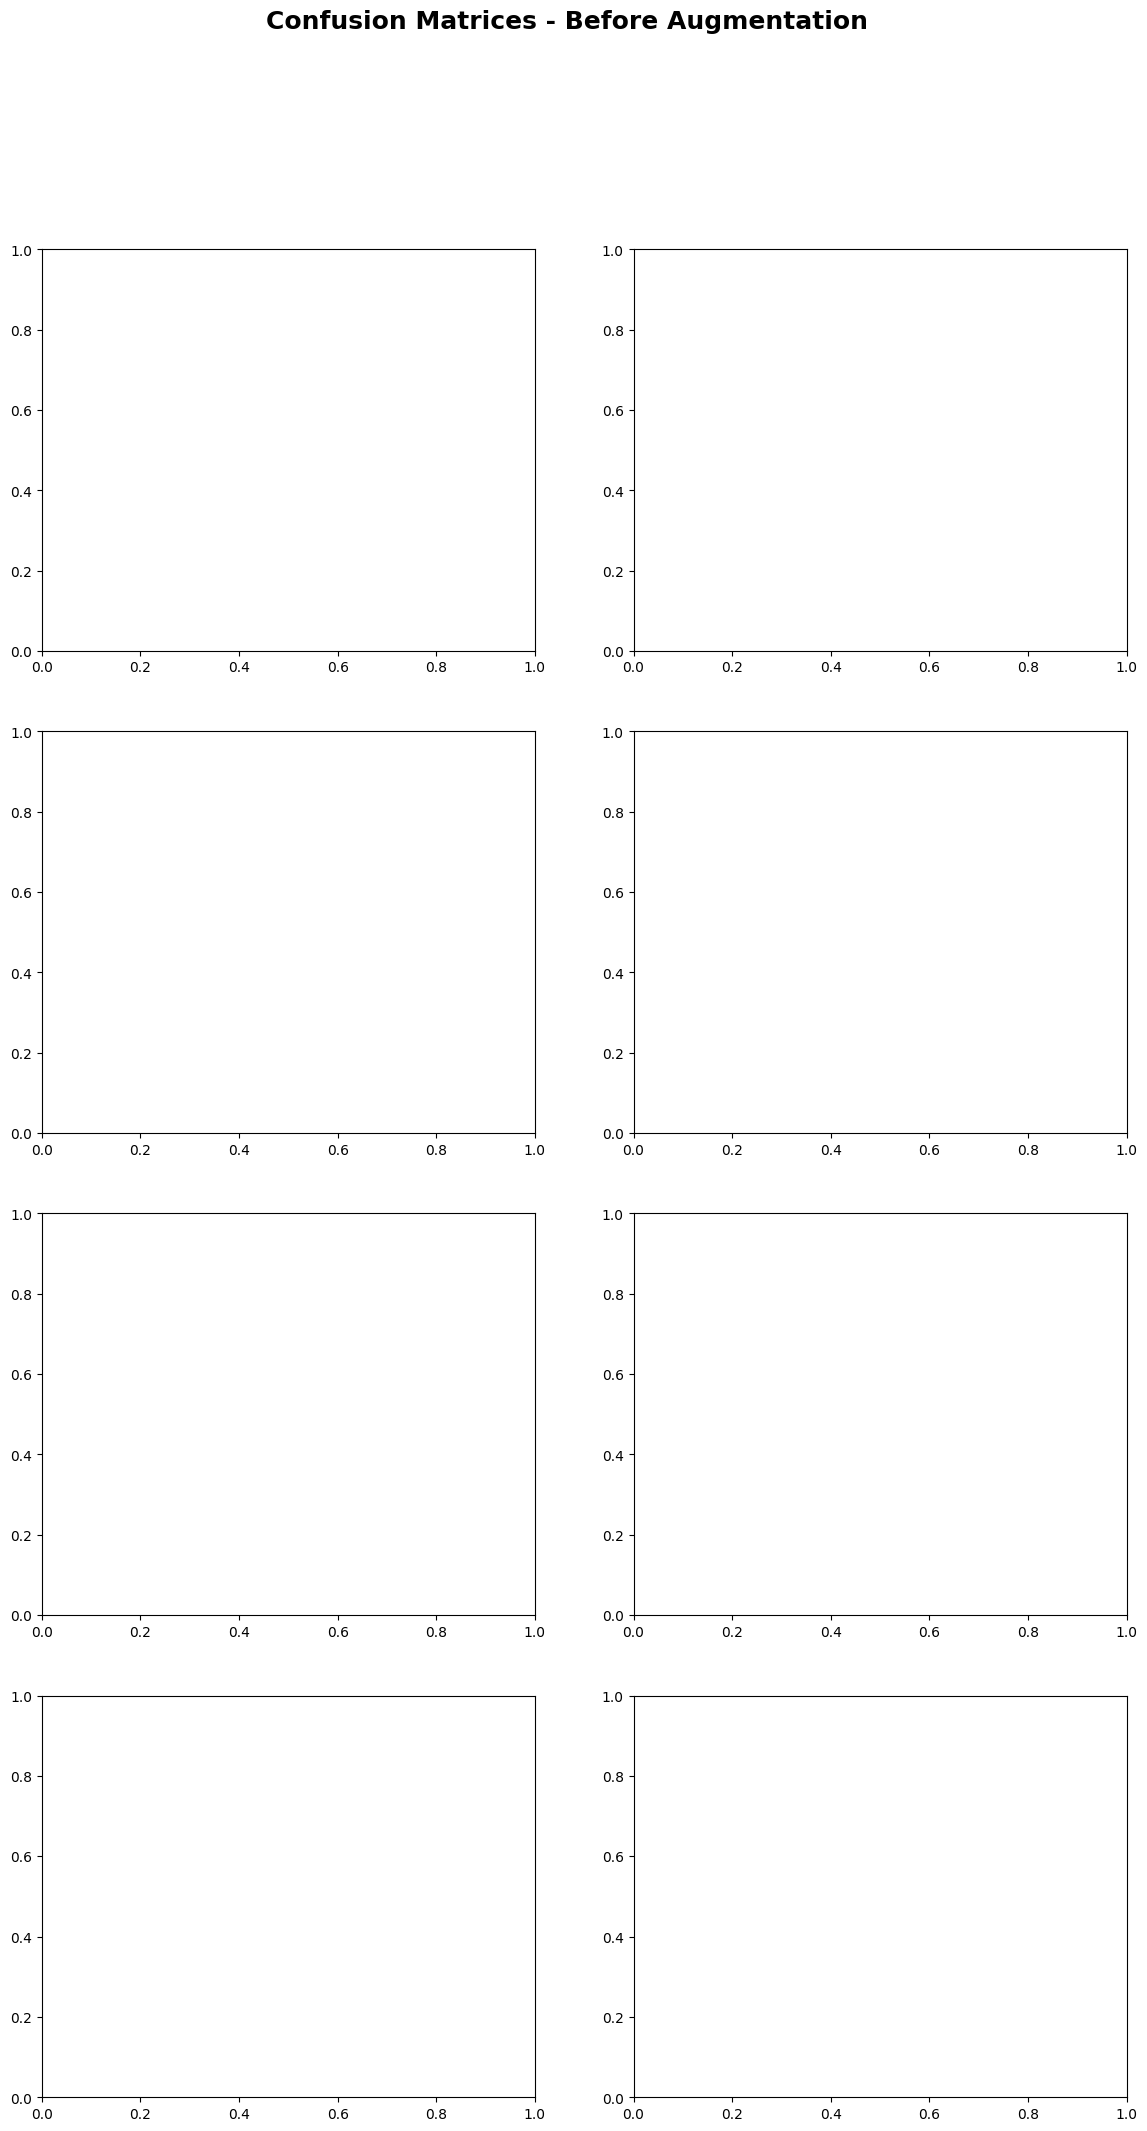

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Number of models
num_models = len(model_names)

# Calculate the number of rows and columns for the grid
num_cols = 2  # Display in 2 columns
num_rows = (num_models + num_cols - 1) // num_cols  # Round up for odd numbers

# Create figure for all confusion matrices
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
fig.suptitle("Confusion Matrices - Before Augmentation", fontsize=18, fontweight="bold")

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, res in enumerate(results_list):
    model_name = res["Model"]
    conf_matrix = res["Confusion Matrix"] 

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}", fontsize=14)
    axes[idx].set_xlabel("Predicted Labels")
    axes[idx].set_ylabel("True Labels")
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45)

# Hide any unused subplots
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## **After Augementation**